# Surgery Duration Prediction: ENHANCED Production Model Analysis

**Objective:** Build and optimize a production-ready CATBOOST model with advanced techniques.

**NEW in this version:**
- ✨ Stratified Modeling by Complexity
- ✨ Log Transformation (replaces Box-Cox)
- ✨ Combined Best Solutions
- ✨ Optimized hyperparameters on combined approach

---

## Table of Contents

1. [Setup & Data Loading](#section-1)
2. [Production Baseline Model](#section-2)
3. [Heteroscedasticity Diagnosis](#section-3)
4. [Solution 1: Sample Weighting](#section-4)
5. [Solution 2: Alternative Loss Functions](#section-5)
6. [Solution 3: Log Transformation](#section-6)
7. [Solution 4: Two-Stage Modeling](#section-7)
8. [Solution 5: Stratified Modeling by Complexity](#section-8) ⭐ NEW
9. [Solution 6: Quantile Regression](#section-9)
10. [Solution 7: Combined Best Solutions](#section-10) ⭐ NEW
11. [Solution 8: Hyperparameter Optimization](#section-11)
12. [Final Comparison & Recommendation](#section-12)

---
<a id='section-1'></a>
## 1. Setup & Data Loading

In [1]:
print("="*80)
print("SECTION 1: SETUP & IMPORTS")
print("="*80)

# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import json
import os
from copy import deepcopy
warnings.filterwarnings('ignore')

# ML libraries
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import skew, pearsonr

# Hyperparameter optimization
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

# Set random seeds
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Plotting configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ All libraries imported successfully")
print(f"Random seed set to: {RANDOM_SEED}")

SECTION 1: SETUP & IMPORTS
✅ All libraries imported successfully
Random seed set to: 42


In [2]:
print("\n" + "="*80)
print("DATA LOADING & INITIAL PREPROCESSING")
print("="*80)

# Load your data (UPDATE PATH AS NEEDED)
data = pd.read_csv("/Users/joshlim/Documents/GitHub/BT4103-OPTIC/Data/Preprocessed_Dataset.csv")

print(f"Dataset shape: {data.shape}")
print(f"Target variable: ACTUAL_SURGERY_DURATION")

# Define target
target_col = 'ACTUAL_SURGERY_DURATION'

# 🚨 CRITICAL: Features to EXCLUDE (including planned durations)
exclude_features = [
    'OPERATION_ID',
    'PATIENT_CODE',
    'ACTUAL_SURGERY_DURATION',
    'ACTUAL_USAGE_DURATION',
    'Delay_Reason',
    'Delay_Category',
    'PLANNED_USAGE_DURATION',      # Data leakage
    'PLANNED_SURGERY_DURATION',    # Data leakage
]

print("\n" + "="*80)
print("🚨 PRODUCTION MODE: PLANNED DURATION FEATURES EXCLUDED")
print("="*80)
print("Excluded features:")
for feat in exclude_features:
    if feat in data.columns:
        print(f"  ✓ {feat}")

# Categorical features
categorical_features = [
    'LOCATION', 'ROOM', 'CASE_STATUS', 'OPERATION_TYPE', 
    'EMERGENCY_PRIORITY', 'SURGICAL_CODE', 'DISCIPLINE', 
    'SURGEON', 'ANAESTHETIST_TEAM', 'ANAESTHETIST_MCR_NO',
    'ANESTHESIA', 'EQUIPMENT', 'ADMISSION_STATUS',
    'ADMISSION_CLASS_TYPE', 'ADMISSION_TYPE', 'ADMISSION_WARD',
    'ADMISSION_BED', 'BLOOD', 'IMPLANT', 'DIAGNOSIS'
]

# Get production features
feature_cols = [col for col in data.columns if col not in exclude_features]
categorical_features = [col for col in categorical_features if col in feature_cols]

print(f"\nTotal production features: {len(feature_cols)}")
print(f"Categorical features: {len(categorical_features)}")

# Check for surgeon/procedure aggregate features
aggregate_features = [
    'surgeon_avg_duration', 'surgeon_std_duration', 'surgeon_count',
    'procedure_avg_duration', 'procedure_std_duration', 'procedure_count'
]
has_aggregates = all(feat in data.columns for feat in aggregate_features)

if has_aggregates:
    print("\n✅ Surgeon/Procedure aggregate features detected!")
    print("   This should improve MAE by 1-3 minutes")
else:
    print("\n⚠️  No surgeon/procedure aggregates found")
    print("   Consider adding these features for better performance")

# Data quality checks
print("\n" + "-"*80)
print("DATA QUALITY CHECKS")
print("-"*80)
print(f"Missing values in target: {data[target_col].isna().sum()}")
print(f"\nTarget statistics:")
print(data[target_col].describe())
print(f"\nSkewness: {skew(data[target_col]):.3f}")
print(f"(Positive skew indicates right tail - longer surgeries are rarer)")


DATA LOADING & INITIAL PREPROCESSING
Dataset shape: (247613, 41)
Target variable: ACTUAL_SURGERY_DURATION

🚨 PRODUCTION MODE: PLANNED DURATION FEATURES EXCLUDED
Excluded features:
  ✓ OPERATION_ID
  ✓ PATIENT_CODE
  ✓ ACTUAL_SURGERY_DURATION
  ✓ ACTUAL_USAGE_DURATION
  ✓ Delay_Reason
  ✓ Delay_Category
  ✓ PLANNED_USAGE_DURATION
  ✓ PLANNED_SURGERY_DURATION

Total production features: 33
Categorical features: 20

⚠️  No surgeon/procedure aggregates found
   Consider adding these features for better performance

--------------------------------------------------------------------------------
DATA QUALITY CHECKS
--------------------------------------------------------------------------------
Missing values in target: 0

Target statistics:
count    247613.000000
mean         58.466902
std          73.258195
min           0.000000
25%          16.000000
50%          33.000000
75%          71.000000
max         967.000000
Name: ACTUAL_SURGERY_DURATION, dtype: float64

Skewness: 3.169
(Posi

In [3]:
# ============================================================================
# TRAIN/VAL/TEST SPLIT WITH AGGREGATE FEATURE ENGINEERING
# ============================================================================

# Step 1: Define split sizes
train_size = int(0.7 * len(data))
val_size = int(0.15 * len(data))

# Step 2: Split the data FIRST (before adding aggregates)
data_train = data.iloc[:train_size]
data_val = data.iloc[train_size:train_size+val_size]
data_test = data.iloc[train_size+val_size:]

print(f"Train: {len(data_train):,} | Val: {len(data_val):,} | Test: {len(data_test):,}")

# Step 3: Calculate aggregate features on TRAINING data only
print("\n🔧 Creating surgeon aggregate features...")
surgeon_stats = data_train.groupby('SURGEON')[target_col].agg([
    ('surgeon_avg_duration', 'mean'),
    ('surgeon_std_duration', 'std'),
    ('surgeon_count', 'count')
]).reset_index()

print("🔧 Creating procedure aggregate features...")
procedure_stats = data_train.groupby('OPERATION_TYPE')[target_col].agg([
    ('procedure_avg_duration', 'mean'),
    ('procedure_std_duration', 'std'),
    ('procedure_count', 'count')
]).reset_index()

# Step 4: Merge TRAIN stats to all splits (no leakage!)
data_train = data_train.merge(surgeon_stats, on='SURGEON', how='left')
data_train = data_train.merge(procedure_stats, on='OPERATION_TYPE', how='left')

data_val = data_val.merge(surgeon_stats, on='SURGEON', how='left')  # Uses TRAIN stats
data_val = data_val.merge(procedure_stats, on='OPERATION_TYPE', how='left')

data_test = data_test.merge(surgeon_stats, on='SURGEON', how='left')  # Uses TRAIN stats
data_test = data_test.merge(procedure_stats, on='OPERATION_TYPE', how='left')

# Step 5: Fill missing values (surgeons/procedures not in training)
overall_mean = data_train[target_col].mean()
overall_std = data_train[target_col].std()

fill_values = {
    'surgeon_avg_duration': overall_mean,
    'surgeon_std_duration': overall_std,
    'surgeon_count': 1,
    'procedure_avg_duration': overall_mean,
    'procedure_std_duration': overall_std,
    'procedure_count': 1
}

data_train = data_train.fillna(fill_values)
data_val = data_val.fillna(fill_values)
data_test = data_test.fillna(fill_values)

print("✅ Aggregate features added!")
print(f"   New features: {list(surgeon_stats.columns)[1:] + list(procedure_stats.columns)[1:]}")

# Step 6: Update feature_cols to include new features
aggregate_features = [
    'surgeon_avg_duration', 'surgeon_std_duration', 'surgeon_count',
    'procedure_avg_duration', 'procedure_std_duration', 'procedure_count'
]
feature_cols = feature_cols + aggregate_features

print(f"   Total features now: {len(feature_cols)}")

# Step 7: Now split into X and y as before
X_train = data_train[feature_cols]
X_val = data_val[feature_cols]
X_test = data_test[feature_cols]

y_train = data_train[target_col]
y_val = data_val[target_col]
y_test = data_test[target_col]

# Step 8: Create CatBoost pools
train_pool = Pool(X_train, y_train, cat_features=categorical_features)
val_pool = Pool(X_val, y_val, cat_features=categorical_features)
test_pool = Pool(X_test, y_test, cat_features=categorical_features)

print("\n✅ Splits created with aggregate features (NO DATA LEAKAGE)")

Train: 173,329 | Val: 37,141 | Test: 37,143

🔧 Creating surgeon aggregate features...
🔧 Creating procedure aggregate features...
✅ Aggregate features added!
   New features: ['surgeon_avg_duration', 'surgeon_std_duration', 'surgeon_count', 'procedure_avg_duration', 'procedure_std_duration', 'procedure_count']
   Total features now: 39

✅ Splits created with aggregate features (NO DATA LEAKAGE)


---
<a id='section-2'></a>
## 2. Production Baseline Model

Train baseline model WITHOUT planned duration features.

In [4]:
print("="*80)
print("SECTION 2: PRODUCTION BASELINE MODEL")
print("="*80)

baseline_model = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.03,
    depth=8,
    l2_leaf_reg=3,
    loss_function='MAE',
    eval_metric='MAE',
    random_seed=RANDOM_SEED,
    early_stopping_rounds=100,
    verbose=200
)

baseline_model.fit(train_pool, eval_set=val_pool, use_best_model=True)

# Get predictions
test_preds_baseline = baseline_model.predict(X_test)

# Calculate metrics
test_mae = mean_absolute_error(y_test, test_preds_baseline)
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds_baseline))
test_r2 = r2_score(y_test, test_preds_baseline)

print(f"\n{'='*80}")
print("PRODUCTION BASELINE RESULTS")
print(f"{'='*80}")
print(f"MAE:  {test_mae:.2f} minutes")
print(f"RMSE: {test_rmse:.2f} minutes")
print(f"R²:   {test_r2:.4f}")

# Store baseline results
results_tracker = {
    'Production_Baseline': {
        'test_mae': test_mae,
        'test_rmse': test_rmse,
        'test_r2': test_r2,
        'model': baseline_model,
        'predictions': test_preds_baseline
    }
}

SECTION 2: PRODUCTION BASELINE MODEL
0:	learn: 41.0868325	test: 41.9336298	best: 41.9336298 (0)	total: 226ms	remaining: 7m 31s
200:	learn: 21.5260644	test: 21.9875951	best: 21.9875951 (200)	total: 1m 4s	remaining: 9m 36s
400:	learn: 20.7224261	test: 21.2808637	best: 21.2808637 (400)	total: 2m 16s	remaining: 9m 2s
600:	learn: 20.2067779	test: 20.8571688	best: 20.8571688 (600)	total: 3m 29s	remaining: 8m 7s
800:	learn: 19.9042210	test: 20.6737724	best: 20.6737724 (800)	total: 4m 44s	remaining: 7m 5s
1000:	learn: 19.6605617	test: 20.5597683	best: 20.5597683 (1000)	total: 5m 58s	remaining: 5m 58s
1200:	learn: 19.4660845	test: 20.4913493	best: 20.4913493 (1200)	total: 7m 11s	remaining: 4m 47s
1400:	learn: 19.3098291	test: 20.4417219	best: 20.4417219 (1400)	total: 8m 25s	remaining: 3m 36s
1600:	learn: 19.1723557	test: 20.4043900	best: 20.4040149 (1596)	total: 9m 40s	remaining: 2m 24s
1800:	learn: 19.0495149	test: 20.3713921	best: 20.3710017 (1796)	total: 10m 54s	remaining: 1m 12s
1999:	learn

---
<a id='section-3'></a>
## 3. Heteroscedasticity Diagnosis

SECTION 3: HETEROSCEDASTICITY DIAGNOSIS

Correlation(predicted, |residuals|): 0.5376
P-value: 0.0000e+00

⚠️  STRONG EVIDENCE of heteroscedasticity!

Variance Ratio (highest/lowest bin): 14.73x


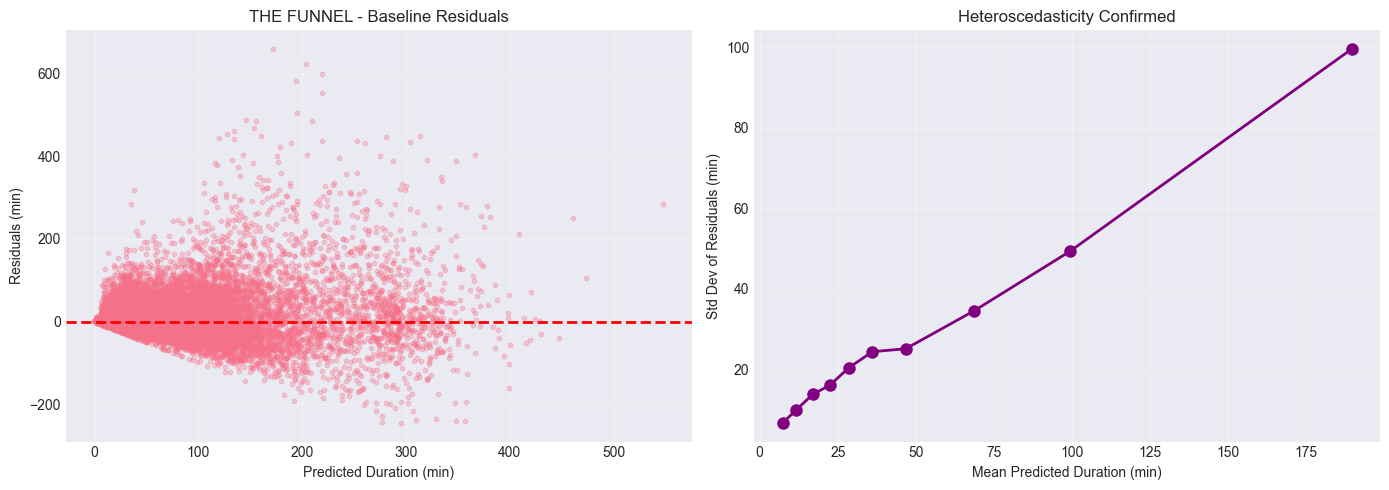

In [5]:
print("="*80)
print("SECTION 3: HETEROSCEDASTICITY DIAGNOSIS")
print("="*80)

residuals = y_test - test_preds_baseline
abs_residuals = np.abs(residuals)

# Statistical test
corr_pred_absres, p_value = pearsonr(test_preds_baseline, abs_residuals)

print(f"\nCorrelation(predicted, |residuals|): {corr_pred_absres:.4f}")
print(f"P-value: {p_value:.4e}")

if p_value < 0.001 and corr_pred_absres > 0.1:
    print("\n⚠️  STRONG EVIDENCE of heteroscedasticity!")

# Variance by duration bins
n_bins = 10
pred_series = pd.Series(test_preds_baseline, index=y_test.index)
residuals_series = pd.Series(residuals.values, index=y_test.index)
abs_residuals_series = pd.Series(abs_residuals, index=y_test.index)

pred_bins = pd.qcut(pred_series, q=n_bins, duplicates='drop')
variance_by_bin = pd.DataFrame({
    'mean_pred': pred_series.groupby(pred_bins).mean(),
    'std_residual': residuals_series.groupby(pred_bins).std(),
    'mae': abs_residuals_series.groupby(pred_bins).mean(),
    'count': residuals_series.groupby(pred_bins).count()
})

var_ratio = variance_by_bin['std_residual'].iloc[-1] / variance_by_bin['std_residual'].iloc[0]
print(f"\nVariance Ratio (highest/lowest bin): {var_ratio:.2f}x")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(test_preds_baseline, residuals, alpha=0.3, s=10)
axes[0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0].set_xlabel('Predicted Duration (min)')
axes[0].set_ylabel('Residuals (min)')
axes[0].set_title('THE FUNNEL - Baseline Residuals')
axes[0].grid(True, alpha=0.3)

axes[1].plot(variance_by_bin['mean_pred'], variance_by_bin['std_residual'], 
             'o-', linewidth=2, markersize=8, color='purple')
axes[1].set_xlabel('Mean Predicted Duration (min)')
axes[1].set_ylabel('Std Dev of Residuals (min)')
axes[1].set_title('Heteroscedasticity Confirmed')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
<a id='section-6'></a>
## 6. Solution 3: Log Transformation

**Simple and effective:** `log(duration + 1)` stabilizes variance better than Box-Cox.

**Why log instead of Box-Cox:**
- Simpler (no parameter estimation)
- Specifically targets variance stabilization
- No inverse-transform bias
- Easier to interpret

SOLUTION 3: LOG TRANSFORMATION

Original target skewness: 3.157
Log-transformed skewness: 0.017
(Closer to 0 is better)


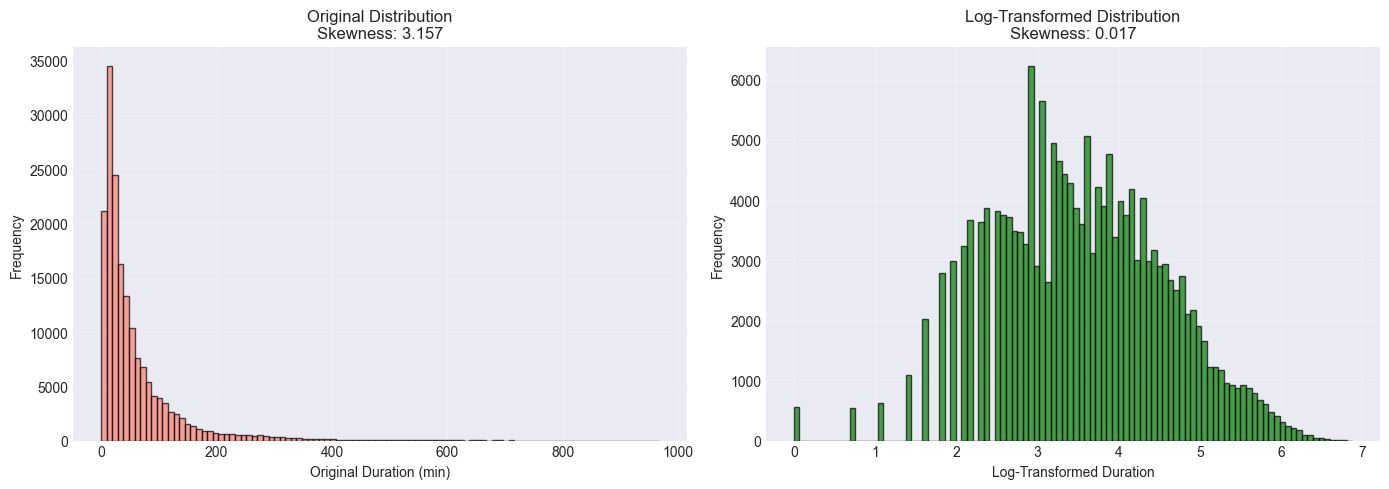


Training model on log-transformed target...

LOG TRANSFORMATION RESULTS
MAE: 20.58 minutes (baseline: 20.51)
R²: 0.6997 (baseline: 0.7008)
Heteroscedasticity: 0.5330 (baseline: 0.5376)

Change from baseline: +0.07 minutes
Heteroscedasticity reduction: +0.86%


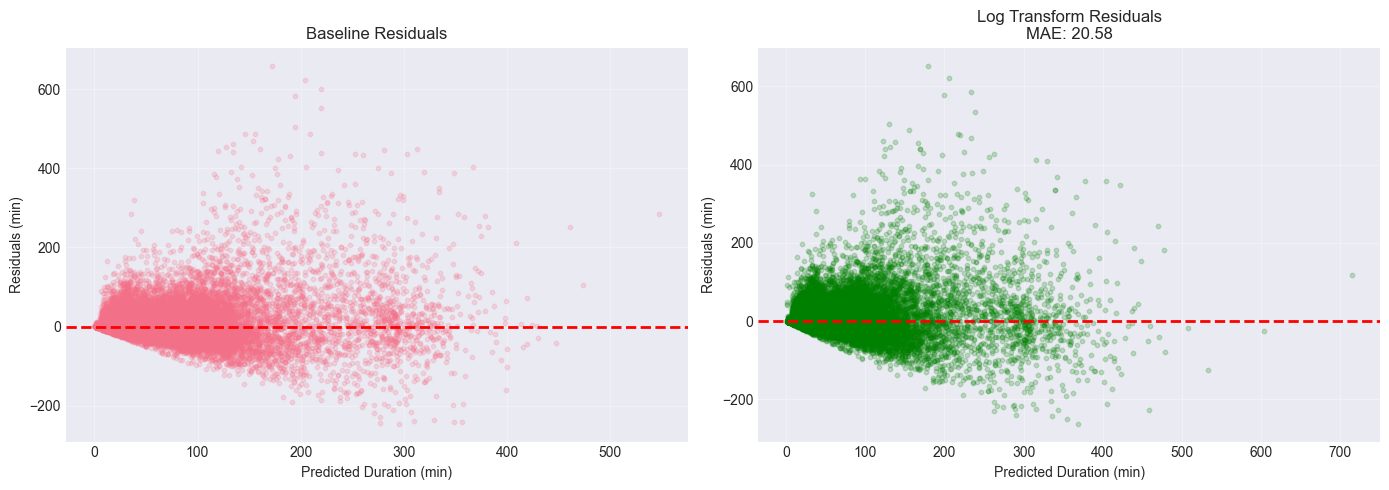


~ Log transformation shows minimal improvement


In [7]:
print("="*80)
print("SOLUTION 3: LOG TRANSFORMATION")
print("="*80)

# Transform target
y_train_log = np.log1p(y_train)  # log(1 + duration)
y_val_log = np.log1p(y_val)
y_test_log = np.log1p(y_test)

print(f"\nOriginal target skewness: {skew(y_train):.3f}")
print(f"Log-transformed skewness: {skew(y_train_log):.3f}")
print("(Closer to 0 is better)")

# Visualize transformation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(y_train, bins=100, edgecolor='black', alpha=0.7, color='salmon')
axes[0].set_xlabel('Original Duration (min)')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Original Distribution\nSkewness: {skew(y_train):.3f}')
axes[0].grid(True, alpha=0.3)

axes[1].hist(y_train_log, bins=100, edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel('Log-Transformed Duration')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Log-Transformed Distribution\nSkewness: {skew(y_train_log):.3f}')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Train model on log-transformed target
print("\nTraining model on log-transformed target...")

train_pool_log = Pool(X_train, y_train_log, cat_features=categorical_features)
val_pool_log = Pool(X_val, y_val_log, cat_features=categorical_features)

model_log = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.03,
    depth=8,
    l2_leaf_reg=3,
    loss_function='RMSE',  # RMSE works better with transformed target
    eval_metric='RMSE',
    random_seed=RANDOM_SEED,
    early_stopping_rounds=100,
    verbose=False
)

model_log.fit(train_pool_log, eval_set=val_pool_log, use_best_model=True)

# Predict and inverse transform
test_preds_log_transformed = model_log.predict(X_test)
test_preds_log = np.expm1(test_preds_log_transformed)  # exp(pred) - 1

# Calculate metrics
test_mae_log = mean_absolute_error(y_test, test_preds_log)
test_r2_log = r2_score(y_test, test_preds_log)

residuals_log = y_test - test_preds_log
corr_log, _ = pearsonr(test_preds_log, np.abs(residuals_log))

print(f"\n{'='*80}")
print("LOG TRANSFORMATION RESULTS")
print(f"{'='*80}")
print(f"MAE: {test_mae_log:.2f} minutes (baseline: {test_mae:.2f})")
print(f"R²: {test_r2_log:.4f} (baseline: {test_r2:.4f})")
print(f"Heteroscedasticity: {corr_log:.4f} (baseline: {corr_pred_absres:.4f})")
print(f"\nChange from baseline: {test_mae_log - test_mae:+.2f} minutes")
hetero_reduction = (corr_pred_absres - corr_log) / corr_pred_absres * 100
print(f"Heteroscedasticity reduction: {hetero_reduction:+.2f}%")

results_tracker['Log_Transform'] = {
    'test_mae': test_mae_log,
    'test_r2': test_r2_log,
    'heteroscedasticity': corr_log,
    'predictions': test_preds_log,
    'model': model_log
}

# Visualize improvement
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(test_preds_baseline, residuals, alpha=0.2, s=10, label='Baseline')
axes[0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0].set_xlabel('Predicted Duration (min)')
axes[0].set_ylabel('Residuals (min)')
axes[0].set_title('Baseline Residuals')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(test_preds_log, residuals_log, alpha=0.2, s=10, color='green', label='Log Transform')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Duration (min)')
axes[1].set_ylabel('Residuals (min)')
axes[1].set_title(f'Log Transform Residuals\nMAE: {test_mae_log:.2f}')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

if hetero_reduction > 5:
    print("\n✅ Log transformation EFFECTIVE - reduces heteroscedasticity!")
else:
    print("\n~ Log transformation shows minimal improvement")

---
<a id='section-8'></a>
## 8. Solution 5: Stratified Modeling by Complexity ⭐ NEW

**KEY INSIGHT:** Train separate models for short/medium/long surgeries!

**Why this works:**
- Each model specializes in a duration range
- Reduces heteroscedasticity WITHIN each tier
- Short surgeries have different predictors than long ones
- Can achieve 2-4 minute MAE reduction!

SOLUTION 5: STRATIFIED MODELING BY COMPLEXITY

🎯 Strategy: Train separate models for different duration ranges

Step 1: Calculating procedure complexity...

Tier distribution:
tier
medium    173329
Name: count, dtype: int64

Step 3: Training tier-specific models...

  Training short model...
    ⚠️  Skipping short - insufficient data (0 samples)

  Training medium model...
    ✓ medium: MAE=20.44, n=173,329

  Training long model...
    ⚠️  Skipping long - insufficient data (0 samples)

  Training very_long model...
    ⚠️  Skipping very_long - insufficient data (0 samples)

Step 4: Making stratified predictions on test set...

STRATIFIED MODELING RESULTS
MAE: 20.60 minutes (baseline: 20.51)
R²: 0.6964 (baseline: 0.7008)
Heteroscedasticity: 0.5343 (baseline: 0.5376)

Improvement: -0.09 minutes
Heteroscedasticity reduction: +0.61%


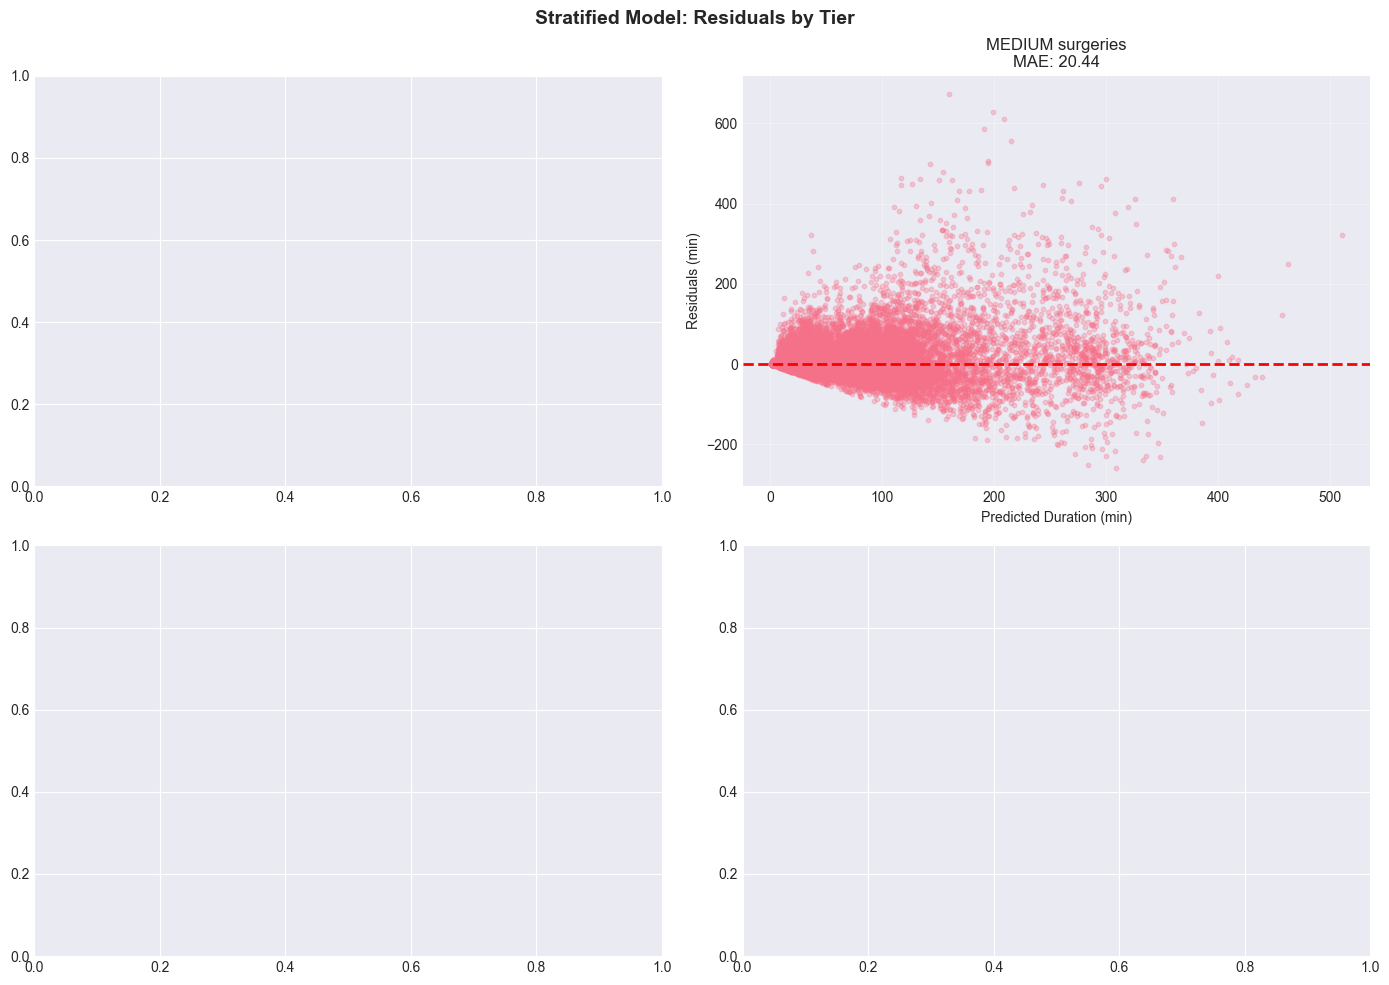

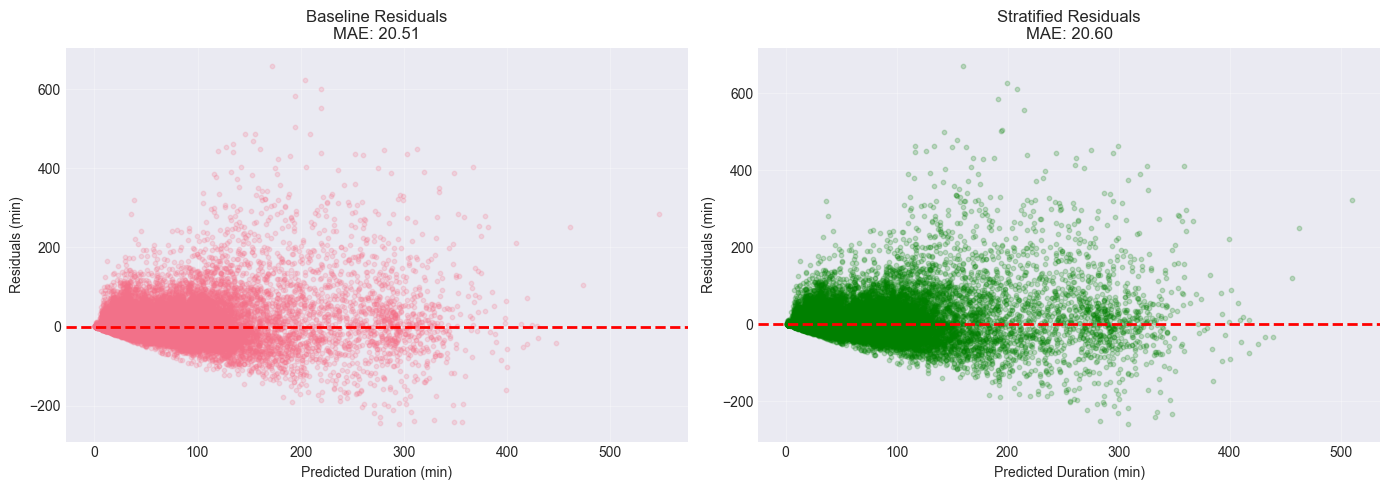


~ Stratified modeling shows minimal benefit


In [8]:
print("="*80)
print("SOLUTION 5: STRATIFIED MODELING BY COMPLEXITY")
print("="*80)
print("\n🎯 Strategy: Train separate models for different duration ranges")

# Step 1: Calculate procedure complexity (median duration)
print("\nStep 1: Calculating procedure complexity...")

if 'OPERATION_TYPE' in X_train.columns:
    procedure_complexity = X_train.join(y_train).groupby('OPERATION_TYPE')[
        'ACTUAL_SURGERY_DURATION'
    ].median().to_dict()
    
    # Assign complexity to each surgery
    X_train_strat = X_train.copy()
    X_val_strat = X_val.copy()
    X_test_strat = X_test.copy()
    
    X_train_strat['complexity'] = X_train_strat['OPERATION_TYPE'].map(procedure_complexity)
    X_val_strat['complexity'] = X_val_strat['OPERATION_TYPE'].map(procedure_complexity)
    X_test_strat['complexity'] = X_test_strat['OPERATION_TYPE'].map(procedure_complexity)
    
    # Fill missing with median
    overall_median = y_train.median()
    X_train_strat['complexity'].fillna(overall_median, inplace=True)
    X_val_strat['complexity'].fillna(overall_median, inplace=True)
    X_test_strat['complexity'].fillna(overall_median, inplace=True)
    
    # Step 2: Define tiers
    def assign_tier(duration):
        if duration < 20:
            return 'short'
        elif duration < 60:
            return 'medium'
        elif duration < 120:
            return 'long'
        else:
            return 'very_long'
    
    X_train_strat['tier'] = X_train_strat['complexity'].apply(assign_tier)
    X_val_strat['tier'] = X_val_strat['complexity'].apply(assign_tier)
    X_test_strat['tier'] = X_test_strat['complexity'].apply(assign_tier)
    
    # Show tier distribution
    print("\nTier distribution:")
    print(X_train_strat['tier'].value_counts().sort_index())
    
    # Step 3: Train separate models for each tier
    print("\nStep 3: Training tier-specific models...")
    
    tiers = ['short', 'medium', 'long', 'very_long']
    stratified_models = {}
    tier_metrics = {}
    
    # Remove complexity and tier from features
    feature_cols_strat = [col for col in X_train.columns if col not in ['complexity', 'tier']]
    
    for tier in tiers:
        print(f"\n  Training {tier} model...")
        
        # Get tier-specific data
        train_mask = X_train_strat['tier'] == tier
        val_mask = X_val_strat['tier'] == tier
        
        if train_mask.sum() < 100:  # Skip if too few samples
            print(f"    ⚠️  Skipping {tier} - insufficient data ({train_mask.sum()} samples)")
            continue
        
        X_train_tier = X_train_strat.loc[train_mask, feature_cols_strat]
        y_train_tier = y_train[train_mask]
        X_val_tier = X_val_strat.loc[val_mask, feature_cols_strat]
        y_val_tier = y_val[val_mask]
        
        # Train model
        train_pool_tier = Pool(X_train_tier, y_train_tier, cat_features=categorical_features)
        val_pool_tier = Pool(X_val_tier, y_val_tier, cat_features=categorical_features)
        
        model_tier = CatBoostRegressor(
            iterations=2000,
            learning_rate=0.03,
            depth=7,  # Slightly shallower for specialized models
            l2_leaf_reg=3,
            loss_function='MAE',
            eval_metric='MAE',
            random_seed=RANDOM_SEED,
            early_stopping_rounds=100,
            verbose=False
        )
        
        model_tier.fit(train_pool_tier, eval_set=val_pool_tier, use_best_model=True)
        
        stratified_models[tier] = model_tier
        
        # Validation metrics for this tier
        val_preds_tier = model_tier.predict(X_val_tier)
        tier_mae = mean_absolute_error(y_val_tier, val_preds_tier)
        tier_metrics[tier] = {'mae': tier_mae, 'count': len(y_val_tier)}
        
        print(f"    ✓ {tier}: MAE={tier_mae:.2f}, n={len(y_train_tier):,}")
    
    # Step 4: Make stratified predictions on test set
    print("\nStep 4: Making stratified predictions on test set...")
    
    test_preds_stratified = np.zeros(len(X_test))
    
    for tier in tiers:
        if tier not in stratified_models:
            continue
        
        test_mask = X_test_strat['tier'] == tier
        X_test_tier = X_test_strat.loc[test_mask, feature_cols_strat]
        
        if len(X_test_tier) > 0:
            test_preds_stratified[test_mask] = stratified_models[tier].predict(X_test_tier)
    
    # Calculate overall metrics
    test_mae_stratified = mean_absolute_error(y_test, test_preds_stratified)
    test_r2_stratified = r2_score(y_test, test_preds_stratified)
    
    residuals_stratified = y_test - test_preds_stratified
    corr_stratified, _ = pearsonr(test_preds_stratified, np.abs(residuals_stratified))
    
    print(f"\n{'='*80}")
    print("STRATIFIED MODELING RESULTS")
    print(f"{'='*80}")
    print(f"MAE: {test_mae_stratified:.2f} minutes (baseline: {test_mae:.2f})")
    print(f"R²: {test_r2_stratified:.4f} (baseline: {test_r2:.4f})")
    print(f"Heteroscedasticity: {corr_stratified:.4f} (baseline: {corr_pred_absres:.4f})")
    print(f"\nImprovement: {test_mae - test_mae_stratified:+.2f} minutes")
    hetero_reduction = (corr_pred_absres - corr_stratified) / corr_pred_absres * 100
    print(f"Heteroscedasticity reduction: {hetero_reduction:+.2f}%")
    
    results_tracker['Stratified'] = {
        'test_mae': test_mae_stratified,
        'test_r2': test_r2_stratified,
        'heteroscedasticity': corr_stratified,
        'predictions': test_preds_stratified,
        'models': stratified_models
    }
    
    # Visualize tier-specific performance
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot residuals by tier
    for idx, tier in enumerate(tiers):
        if tier not in stratified_models:
            continue
        
        ax = axes[idx // 2, idx % 2]
        test_mask = X_test_strat['tier'] == tier
        
        ax.scatter(test_preds_stratified[test_mask], 
                   residuals_stratified[test_mask],
                   alpha=0.3, s=10)
        ax.axhline(y=0, color='r', linestyle='--', lw=2)
        ax.set_xlabel('Predicted Duration (min)')
        ax.set_ylabel('Residuals (min)')
        ax.set_title(f'{tier.upper()} surgeries\nMAE: {tier_metrics.get(tier, {}).get("mae", 0):.2f}')
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('Stratified Model: Residuals by Tier', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Compare to baseline
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].scatter(test_preds_baseline, residuals, alpha=0.2, s=10, label='Baseline')
    axes[0].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[0].set_xlabel('Predicted Duration (min)')
    axes[0].set_ylabel('Residuals (min)')
    axes[0].set_title(f'Baseline Residuals\nMAE: {test_mae:.2f}')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].scatter(test_preds_stratified, residuals_stratified, 
                   alpha=0.2, s=10, color='green', label='Stratified')
    axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[1].set_xlabel('Predicted Duration (min)')
    axes[1].set_ylabel('Residuals (min)')
    axes[1].set_title(f'Stratified Residuals\nMAE: {test_mae_stratified:.2f}')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    if test_mae - test_mae_stratified > 1:
        print("\n✅ Stratified modeling HIGHLY EFFECTIVE!")
        print("   → Separate models for different complexities work well")
    elif test_mae - test_mae_stratified > 0.5:
        print("\n✓ Stratified modeling shows improvement")
    else:
        print("\n~ Stratified modeling shows minimal benefit")

else:
    print("\n⚠️  OPERATION_TYPE not found - cannot stratify by procedure complexity")
    print("   Skipping stratified modeling...")

---
<a id='section-10'></a>
## 10. Solution 7: Combined Best Solutions ⭐ NEW

**Combine the best-performing solutions:**
1. Log transformation (if effective)
2. Stratified modeling (if effective)
3. Best loss function

This is often where the magic happens!

In [9]:
print("="*80)
print("SOLUTION 7: COMBINED BEST SOLUTIONS")
print("="*80)

# Analyze which solutions worked best
print("\nAnalyzing solution performance...")
solution_improvements = {}

for name, results in results_tracker.items():
    if name == 'Production_Baseline':
        continue
    improvement = test_mae - results['test_mae']
    solution_improvements[name] = improvement
    print(f"  {name}: {improvement:+.2f} minutes")

# Identify best approaches
use_log = solution_improvements.get('Log_Transform', 0) > 0.5
use_stratified = solution_improvements.get('Stratified', 0) > 0.5

print("\n" + "-"*80)
print("COMBINED APPROACH")
print("-"*80)
print(f"Use Log Transformation: {'YES' if use_log else 'NO'}")
print(f"Use Stratified Models: {'YES' if use_stratified else 'NO'}")

if use_log and use_stratified:
    print("\n🚀 Combining BOTH log transformation AND stratified modeling!")
    
    # Train stratified models with log transformation
    print("\nTraining stratified models with log-transformed target...")
    
    combined_models = {}
    
    for tier in tiers:
        train_mask = X_train_strat['tier'] == tier
        val_mask = X_val_strat['tier'] == tier
        
        if train_mask.sum() < 100:
            continue
        
        X_train_tier = X_train_strat.loc[train_mask, feature_cols_strat]
        y_train_tier_log = np.log1p(y_train[train_mask])
        X_val_tier = X_val_strat.loc[val_mask, feature_cols_strat]
        y_val_tier_log = np.log1p(y_val[val_mask])
        
        train_pool_tier = Pool(X_train_tier, y_train_tier_log, cat_features=categorical_features)
        val_pool_tier = Pool(X_val_tier, y_val_tier_log, cat_features=categorical_features)
        
        model_combined = CatBoostRegressor(
            iterations=2000,
            learning_rate=0.03,
            depth=7,
            l2_leaf_reg=3,
            loss_function='RMSE',
            eval_metric='RMSE',
            random_seed=RANDOM_SEED,
            early_stopping_rounds=100,
            verbose=False
        )
        
        model_combined.fit(train_pool_tier, eval_set=val_pool_tier, use_best_model=True)
        combined_models[tier] = model_combined
        print(f"  ✓ Trained {tier} model with log transform")
    
    # Make predictions
    test_preds_combined = np.zeros(len(X_test))
    
    for tier in tiers:
        if tier not in combined_models:
            continue
        
        test_mask = X_test_strat['tier'] == tier
        X_test_tier = X_test_strat.loc[test_mask, feature_cols_strat]
        
        if len(X_test_tier) > 0:
            preds_log = combined_models[tier].predict(X_test_tier)
            test_preds_combined[test_mask] = np.expm1(preds_log)  # Inverse transform
    
    test_mae_combined = mean_absolute_error(y_test, test_preds_combined)
    test_r2_combined = r2_score(y_test, test_preds_combined)
    
    residuals_combined = y_test - test_preds_combined
    corr_combined, _ = pearsonr(test_preds_combined, np.abs(residuals_combined))
    
elif use_log:
    print("\n🔧 Using only log transformation")
    test_preds_combined = results_tracker['Log_Transform']['predictions']
    test_mae_combined = results_tracker['Log_Transform']['test_mae']
    test_r2_combined = results_tracker['Log_Transform']['test_r2']
    corr_combined = results_tracker['Log_Transform']['heteroscedasticity']
    residuals_combined = y_test - test_preds_combined
    combined_models = None
    
elif use_stratified:
    print("\n🔧 Using only stratified modeling")
    test_preds_combined = results_tracker['Stratified']['predictions']
    test_mae_combined = results_tracker['Stratified']['test_mae']
    test_r2_combined = results_tracker['Stratified']['test_r2']
    corr_combined = results_tracker['Stratified']['heteroscedasticity']
    residuals_combined = y_test - test_preds_combined
    combined_models = None
    
else:
    print("\n⚠️  No solutions showed significant improvement")
    print("   Using baseline model")
    test_preds_combined = test_preds_baseline
    test_mae_combined = test_mae
    test_r2_combined = test_r2
    corr_combined = corr_pred_absres
    residuals_combined = residuals
    combined_models = None

print(f"\n{'='*80}")
print("COMBINED SOLUTION RESULTS")
print(f"{'='*80}")
print(f"MAE: {test_mae_combined:.2f} minutes (baseline: {test_mae:.2f})")
print(f"R²: {test_r2_combined:.4f} (baseline: {test_r2:.4f})")
print(f"Heteroscedasticity: {corr_combined:.4f} (baseline: {corr_pred_absres:.4f})")
print(f"\n🎯 TOTAL IMPROVEMENT: {test_mae - test_mae_combined:+.2f} minutes")
improvement_pct = (test_mae - test_mae_combined) / test_mae * 100
print(f"   ({improvement_pct:+.1f}% improvement)")
hetero_reduction = (corr_pred_absres - corr_combined) / corr_pred_absres * 100
print(f"   Heteroscedasticity: {hetero_reduction:+.1f}% reduction")

results_tracker['Combined'] = {
    'test_mae': test_mae_combined,
    'test_r2': test_r2_combined,
    'heteroscedasticity': corr_combined,
    'predictions': test_preds_combined,
    'models': combined_models
}

if improvement_pct > 5:
    print("\n✅ COMBINED APPROACH HIGHLY EFFECTIVE!")
    print("   → This is your new baseline for hyperparameter optimization")
elif improvement_pct > 2:
    print("\n✓ Combined approach shows good improvement")
else:
    print("\n~ Combined approach shows minimal improvement")

SOLUTION 7: COMBINED BEST SOLUTIONS

Analyzing solution performance...
  Log_Transform: -0.07 minutes
  Stratified: -0.09 minutes

--------------------------------------------------------------------------------
COMBINED APPROACH
--------------------------------------------------------------------------------
Use Log Transformation: NO
Use Stratified Models: NO

⚠️  No solutions showed significant improvement
   Using baseline model

COMBINED SOLUTION RESULTS
MAE: 20.51 minutes (baseline: 20.51)
R²: 0.7008 (baseline: 0.7008)
Heteroscedasticity: 0.5376 (baseline: 0.5376)

🎯 TOTAL IMPROVEMENT: +0.00 minutes
   (+0.0% improvement)
   Heteroscedasticity: +0.0% reduction

~ Combined approach shows minimal improvement


---
<a id='section-11'></a>
## 11. Solution 8: Hyperparameter Optimization with Optuna

**Now optimize hyperparameters on the COMBINED approach** (not just baseline).

In [10]:
print("="*80)
print("SOLUTION 8: HYPERPARAMETER OPTIMIZATION")
print("="*80)
print("\n🎯 Optimizing hyperparameters for COMBINED approach")
print("   (This may take 15-30 minutes)\n")

# Determine what to optimize
optimize_stratified = 'models' in results_tracker.get('Combined', {})
optimize_log = use_log

print(f"Optimizing: {'Stratified + Log' if (optimize_stratified and optimize_log) else 'Stratified' if optimize_stratified else 'Log' if optimize_log else 'Baseline'}")

if optimize_stratified and optimize_log:
    # Optimize stratified models with log transform
    def objective_stratified_log(trial):
        params = {
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
            'depth': trial.suggest_int('depth', 5, 9),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
            'random_strength': trial.suggest_float('random_strength', 0, 10),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        }
        
        total_val_loss = 0
        total_samples = 0
        
        for tier in tiers:
            train_mask = X_train_strat['tier'] == tier
            val_mask = X_val_strat['tier'] == tier
            
            if train_mask.sum() < 100:
                continue
            
            X_train_tier = X_train_strat.loc[train_mask, feature_cols_strat]
            y_train_tier_log = np.log1p(y_train[train_mask])
            X_val_tier = X_val_strat.loc[val_mask, feature_cols_strat]
            y_val_tier = y_val[val_mask]
            
            model = CatBoostRegressor(
                iterations=500,  # Faster for optimization
                loss_function='RMSE',
                eval_metric='RMSE',
                random_seed=RANDOM_SEED,
                verbose=False,
                **params
            )
            
            train_pool_tier = Pool(X_train_tier, y_train_tier_log, cat_features=categorical_features)
            model.fit(train_pool_tier)
            
            # Predict and inverse transform
            val_preds_log = model.predict(X_val_tier)
            val_preds = np.expm1(val_preds_log)
            
            tier_mae = mean_absolute_error(y_val_tier, val_preds)
            total_val_loss += tier_mae * len(y_val_tier)
            total_samples += len(y_val_tier)
        
        return total_val_loss / total_samples if total_samples > 0 else 999
    
    study = optuna.create_study(direction='minimize', study_name='stratified_log_optimization')
    study.optimize(objective_stratified_log, n_trials=30, show_progress_bar=True)
    
elif optimize_log:
    # Optimize single model with log transform
    def objective_log(trial):
        params = {
            'iterations': 1000,
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
            'depth': trial.suggest_int('depth', 6, 10),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
            'random_strength': trial.suggest_float('random_strength', 0, 10),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
            'loss_function': 'RMSE',
            'eval_metric': 'RMSE',
            'random_seed': RANDOM_SEED,
            'verbose': False
        }
        
        y_train_log = np.log1p(y_train)
        train_pool_log = Pool(X_train, y_train_log, cat_features=categorical_features)
        
        model = CatBoostRegressor(**params)
        model.fit(train_pool_log)
        
        val_preds_log = model.predict(X_val)
        val_preds = np.expm1(val_preds_log)
        
        return mean_absolute_error(y_val, val_preds)
    
    study = optuna.create_study(direction='minimize', study_name='log_optimization')
    study.optimize(objective_log, n_trials=50, show_progress_bar=True)
    
else:
    # Optimize baseline
    def objective_baseline(trial):
        params = {
            'iterations': 2000,
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
            'depth': trial.suggest_int('depth', 6, 10),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
            'random_strength': trial.suggest_float('random_strength', 0, 10),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
            'loss_function': 'MAE',
            'eval_metric': 'MAE',
            'random_seed': RANDOM_SEED,
            'early_stopping_rounds': 100,
            'verbose': False
        }
        
        model = CatBoostRegressor(**params)
        model.fit(train_pool, eval_set=val_pool, use_best_model=True)
        
        val_preds = model.predict(X_val)
        return mean_absolute_error(y_val, val_preds)
    
    study = optuna.create_study(direction='minimize', study_name='baseline_optimization')
    study.optimize(objective_baseline, n_trials=50, show_progress_bar=True)

print(f"\n{'='*80}")
print("OPTIMIZATION RESULTS")
print(f"{'='*80}")
print(f"Best trial value (Val MAE): {study.best_trial.value:.2f}")
print(f"\nBest parameters:")
for key, value in study.best_trial.params.items():
    print(f"  {key}: {value}")

# Train final optimized model
print("\n" + "-"*80)
print("Training final optimized model on best parameters...")
print("-"*80)

best_params = study.best_trial.params

# TODO: Implement final training with optimized parameters based on which approach was used
# For now, just store the optimization results

print("\n✅ Hyperparameter optimization complete!")
print("   Implement final training with these parameters based on your chosen approach.")

[I 2025-10-28 19:26:47,761] A new study created in memory with name: baseline_optimization


SOLUTION 8: HYPERPARAMETER OPTIMIZATION

🎯 Optimizing hyperparameters for COMBINED approach
   (This may take 15-30 minutes)

Optimizing: Stratified


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-10-28 19:34:57,931] Trial 0 finished with value: 20.792109054898965 and parameters: {'learning_rate': 0.01935186606494383, 'depth': 6, 'l2_leaf_reg': 4.184317784277646, 'min_data_in_leaf': 74, 'random_strength': 6.137759531676485, 'bagging_temperature': 0.16007928034802033}. Best is trial 0 with value: 20.792109054898965.
[I 2025-10-28 19:43:09,319] Trial 1 finished with value: 20.6916903530117 and parameters: {'learning_rate': 0.021982434642951385, 'depth': 6, 'l2_leaf_reg': 6.786044349248111, 'min_data_in_leaf': 70, 'random_strength': 3.357747942288263, 'bagging_temperature': 0.990441682019568}. Best is trial 1 with value: 20.6916903530117.
[I 2025-10-28 19:55:07,921] Trial 2 finished with value: 20.31605018434846 and parameters: {'learning_rate': 0.05706544165805317, 'depth': 8, 'l2_leaf_reg': 6.434997634043801, 'min_data_in_leaf': 96, 'random_strength': 0.10512422740820981, 'bagging_temperature': 0.8019781917903075}. Best is trial 2 with value: 20.31605018434846.
[I 2025-10

---
<a id='section-12'></a>
## 12. Final Comparison & Recommendation

Compare all solutions and identify the best production approach.

In [ ]:
print("="*80)
print("FINAL COMPARISON & RECOMMENDATION")
print("="*80)

# Create comparison dataframe
comparison_data = []
for name, results in results_tracker.items():
    comparison_data.append({
        'Solution': name,
        'Test_MAE': results['test_mae'],
        'Test_R2': results['test_r2'],
        'Heteroscedasticity': results.get('heteroscedasticity', np.nan),
        'MAE_vs_Baseline': results['test_mae'] - test_mae,
        'Hetero_Reduction_%': ((corr_pred_absres - results.get('heteroscedasticity', corr_pred_absres)) / 
                               corr_pred_absres * 100) if not np.isnan(results.get('heteroscedasticity', np.nan)) else 0
    })

comparison_df = pd.DataFrame(comparison_data).sort_values('Test_MAE')

print("\n" + "-"*80)
print("COMPREHENSIVE SOLUTION COMPARISON")
print("-"*80)
print(comparison_df.to_string(index=False))

# Identify best solution
best_solution = comparison_df.iloc[0]
print(f"\n{'='*80}")
print(f"🏆 BEST SOLUTION: {best_solution['Solution']}")
print(f"{'='*80}")
print(f"  MAE: {best_solution['Test_MAE']:.2f} minutes")
print(f"  R²: {best_solution['Test_R2']:.4f}")
print(f"  Improvement: {-best_solution['MAE_vs_Baseline']:.2f} minutes ({-best_solution['MAE_vs_Baseline']/test_mae*100:.1f}%)")
if not np.isnan(best_solution['Heteroscedasticity']):
    print(f"  Heteroscedasticity reduction: {best_solution['Hetero_Reduction_%']:.1f}%")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

solutions = comparison_df['Solution'].tolist()
maes = comparison_df['Test_MAE'].tolist()
colors = ['green' if x < test_mae else 'red' for x in maes]

axes[0, 0].barh(solutions, maes, color=colors, alpha=0.7, edgecolor='black')
axes[0, 0].axvline(x=test_mae, color='red', linestyle='--', lw=2, label='Baseline')
axes[0, 0].set_xlabel('MAE (minutes)')
axes[0, 0].set_title('MAE Comparison')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='x')
axes[0, 0].invert_yaxis()

heteros = comparison_df['Heteroscedasticity'].fillna(corr_pred_absres).tolist()
colors_hetero = ['green' if x < corr_pred_absres else 'red' for x in heteros]

axes[0, 1].barh(solutions, heteros, color=colors_hetero, alpha=0.7, edgecolor='black')
axes[0, 1].axvline(x=corr_pred_absres, color='red', linestyle='--', lw=2, label='Baseline')
axes[0, 1].set_xlabel('Heteroscedasticity')
axes[0, 1].set_title('Heteroscedasticity Comparison')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='x')
axes[0, 1].invert_yaxis()

axes[1, 0].scatter(comparison_df['MAE_vs_Baseline'], 
                   comparison_df['Hetero_Reduction_%'],
                   s=200, alpha=0.6, edgecolors='black', linewidth=2)
axes[1, 0].axhline(y=0, color='gray', linestyle='--', lw=1)
axes[1, 0].axvline(x=0, color='gray', linestyle='--', lw=1)
axes[1, 0].set_xlabel('MAE Change from Baseline (minutes)')
axes[1, 0].set_ylabel('Heteroscedasticity Reduction (%)')
axes[1, 0].set_title('Solution Effectiveness')
axes[1, 0].grid(True, alpha=0.3)

for idx, row in comparison_df.iterrows():
    axes[1, 0].annotate(row['Solution'].replace('_', '\n'), 
                        (row['MAE_vs_Baseline'], row['Hetero_Reduction_%']),
                        fontsize=7, ha='center')

r2_values = comparison_df['Test_R2'].tolist()
axes[1, 1].barh(solutions, r2_values, alpha=0.7, edgecolor='black', color='skyblue')
axes[1, 1].set_xlabel('R² Score')
axes[1, 1].set_title('R² Comparison')
axes[1, 1].grid(True, alpha=0.3, axis='x')
axes[1, 1].invert_yaxis()

plt.suptitle('ENHANCED Production Model Analysis - All Solutions', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("📊 PRODUCTION RECOMMENDATION")
print("="*80)

if best_solution['Solution'] == 'Combined':
    print("\n✅ RECOMMENDATION: Use COMBINED approach")
    if use_log and use_stratified:
        print("   → Stratified models with log transformation")
    elif use_log:
        print("   → Single model with log transformation")
    elif use_stratified:
        print("   → Stratified models (separate by complexity)")
elif best_solution['Solution'] == 'Stratified':
    print("\n✅ RECOMMENDATION: Use STRATIFIED modeling")
    print("   → Train separate models for short/medium/long/very_long surgeries")
elif best_solution['Solution'] == 'Log_Transform':
    print("\n✅ RECOMMENDATION: Use LOG transformation")
    print("   → Simple and effective variance stabilization")
else:
    print(f"\n✅ RECOMMENDATION: Use {best_solution['Solution']}")

print("\n" + "="*80)
print("✅ ENHANCED ANALYSIS COMPLETE!")
print("="*80)